In [149]:
from capymoa.ocl.evaluation import ocl_train_eval_loop
from capymoa.ocl.datasets import SplitMNIST
from capymoa.ann import Perceptron
from capymoa.classifier import Finetune
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from torch.optim import Adam
import random

pt = 1 / 72.27
figsize_169 = (455 * pt, 256 * pt)

# use sans-serif computer modern font
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["NewComputerModernSans08"]
# font size
plt.rcParams["font.size"] = 9


def scale_figsize(scale, figsize):
    return (figsize[0] * scale, figsize[1] * scale)

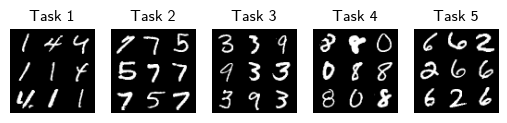

In [151]:
# Plot a figure of the SplitMNIST dataset
def grid_from_dataset(dataset, n=3):
    """Create a grid of images from the dataset."""
    images = []
    rng = random.Random(0)
    for i in range(n**2):
        img, label = dataset[rng.randrange(0, len(dataset))]
        images.append(img)
    grid = make_grid(images, nrow=n)
    return grid.permute(1, 2, 0).numpy()


scenario = SplitMNIST()
scenario.task_schedule

fig, ax = plt.subplots(1, len(scenario.task_schedule), figsize=figsize_169)

for i, task in enumerate(scenario.task_schedule):
    ax[i].imshow(grid_from_dataset(scenario.train_tasks[i]))
    ax[i].set_title(f"Task {i+1}")
    ax[i].axis("off")

fig.savefig("fig/splitmnist.pdf", bbox_inches="tight")

# Continual Learning Evaluation Metrics

In [ ]:
scenario = SplitMNIST()
model = Perceptron(scenario.schema)
learner = Finetune(
    scenario.schema, model, optimizer=Adam(model.parameters(), lr=0.00001)
)
results = ocl_train_eval_loop(
    learner, scenario.train_streams, scenario.test_streams, progress_bar=True
)

Train & Eval:   0%|          | 0/110000 [00:00<?, ?it/s]

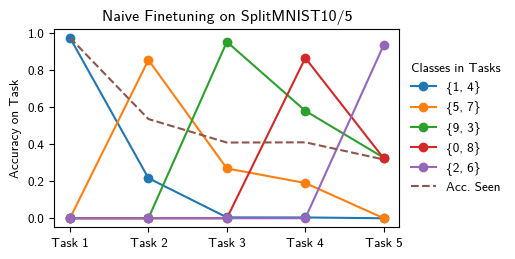

In [ ]:
fig, ax = plt.subplots(
    figsize=(figsize_169[0] * 0.8, figsize_169[1] * 0.7), layout="compressed"
)
ax.plot(
    results.accuracy_matrix,
    "o-",
    label=[f"{classes}" for i, classes in enumerate(scenario.task_schedule)],
)
ax.plot(results.accuracy_seen, "--", label="Acc. Seen")

ax.set_ylabel("Accuracy on Task")
ax.set_title(f"Naive Finetuning on {scenario}")
ax.set_xticks(
    range(len(scenario.task_schedule)),
    [f"Task {i+1}" for i in range(len(scenario.task_schedule))],
)

ax.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
    title="Classes in Tasks",
    ncol=1,
)

fig.savefig("fig/cl_eval_naive.pdf")

# Anytime Online Continual Learning Evaluation Metrics

In [92]:
scenario = SplitMNIST()
model = Perceptron(scenario.schema)
learner = Finetune(
    scenario.schema, model, optimizer=Adam(model.parameters(), lr=0.00001)
)
results = ocl_train_eval_loop(
    learner,
    scenario.train_streams,
    scenario.test_streams,
    progress_bar=True,
    continual_evaluations=30,
)

Train & Eval:   0%|          | 0/1560000 [00:00<?, ?it/s]

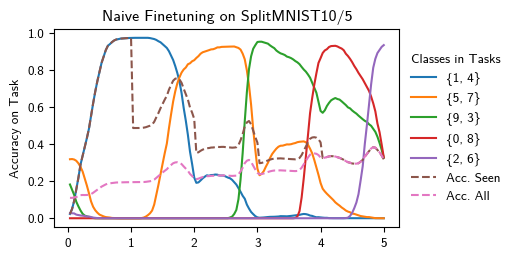

In [123]:
fig, ax = plt.subplots(
    figsize=(figsize_169[0] * 0.8, figsize_169[1] * 0.7), layout="compressed"
)

ax.plot(
    results.anytime_task_index,
    results.anytime_accuracy_matrix,
    "-",
    label=[f"{classes}" for i, classes in enumerate(scenario.task_schedule)],
)

ax.plot(
    results.anytime_task_index, results.anytime_accuracy_seen, "--", label="Acc. Seen"
)
ax.plot(
    results.anytime_task_index, results.anytime_accuracy_all, "--", label="Acc. All"
)

ax.set_ylabel("Accuracy on Task")
ax.set_title(f"Naive Finetuning on {scenario}")
# ax.set_xticks(range(len(scenario.task_schedule)), [f'Task {i+1}' for i in range(len(scenario.task_schedule))])

ax.legend(
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
    title="Classes in Tasks",
    ncol=1,
)

fig.savefig("fig/anytime_cl_eval_naive.pdf")

# Online Accuracy

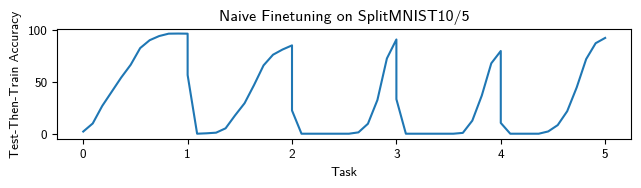

In [148]:
fig, ax = plt.subplots(
    figsize=[figsize_169[0] * 1, figsize_169[1] * 0.5], layout="compressed"
)

ys = results.ttt.metrics_per_window()["accuracy"]
ax.plot(results.ttt_windowed_task_index, ys, label="Low LR")

ax.set_ylabel("Test-Then-Train Accuracy")
ax.set_xlabel("Task")
ax.set_title(f"Naive Finetuning on {scenario}")
fig.savefig("fig/eval_ttt.pdf")